***Final Project Notebook***

In [1]:
import matplotlib.pyplot as plt
# plt.style.use('classic')

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go 
lab_data = pd.read_csv("1 Laboratory Failure-Time and Single-Time Strength Data/ApplianceB.csv")
lab_data


,Data Source,Censoring Indicator,Count,Days,Failure Mode
0,Field,Failed,1,181,Wear
1,Field,Censored,1,95,Censored
2,Field,Censored,1,504,Censored
3,Field,Censored,1,588,Censored
4,Field,Censored,1,386,Censored
...,...,...,...,...,...
393,CrackTest,Failed,1,458,Cracked
394,CrackTest,Failed,1,483,Cracked
395,CrackTest,Failed,1,323,Cracked
396,CrackTest,Failed,1,482,Cracked


In [2]:
field_data = pd.read_csv("2 Field Failure-time Data/ApplianceBField.csv")
field_data

,Data Source,Censoring Indicator,Count,Days,Failure Mode
0,Field,Failed,1,181,Wear
1,Field,Censored,1,95,Censored
2,Field,Censored,1,504,Censored
3,Field,Censored,1,588,Censored
4,Field,Censored,1,386,Censored
...,...,...,...,...,...
364,Field,Censored,8,14,Censored
365,Field,Censored,38,12,Censored
366,Field,Censored,16,10,Censored
367,Field,Censored,1,9,Censored


**Compare the two Datasets here**


In [3]:
lab_data['Data Source'].value_counts()
lab_data_failed = lab_data[lab_data["Censoring Indicator"] == 'Failed']
lab_data["Censoring Indicator"].value_counts()

Censored    257
Failed      141
Name: Censoring Indicator, dtype: int64

In [4]:
lab_data_failed["Failure Mode"].value_counts()

Wear       101
Cracked     40
Name: Failure Mode, dtype: int64

In [5]:
lab_data_failed[lab_data_failed["Days"]==687]

,Data Source,Censoring Indicator,Count,Days,Failure Mode
372,WearTest,Failed,1,687,Wear


In [6]:
total_lab_appliance=lab_data.Count.sum()
total_lab_app_failure = lab_data_failed.Count.sum()
total_lab_app_failure

141

In [7]:
table1 = [["Not Failed", total_lab_appliance-total_lab_app_failure],["Failed", total_lab_app_failure]]
test = pd.DataFrame(table1, columns=["Failed or Not", "Count"])
test

,Failed or Not,Count
0,Not Failed,4617
1,Failed,141


In [8]:
test2 = test.copy()
test2.Count = (test2["Count"]/test2["Count"].sum())
test2
fig1 = px.bar(test2, x=test["Failed or Not"], y="Count", width=800, height=400,
    labels=dict(x="Appliance Status", color="Place"),
    )
fig1.update_layout(
    title="Appliance Status from Lab Study",
    xaxis_title="Appliance Status",
    yaxis_title="Unit Count %",
    font=dict(
        size=18
    )
)
fig1.show()

Lab results for the appliance failure rate over the study period.  In the end, only about **3%** of the units studied failed during accelerated degredation lab tests.  We will compare this later in the notebook with the data collected from the field.

In [9]:
#take the failed rows and divide their count by the days it took for a failure.
array1 = lab_data_failed['Count']/(lab_data_failed['Days']/365)
lab_data_failed['Failures Per Year'] = array1
lab_data_failed['Wear FPY'] =   lab_data_failed[lab_data_failed["Failure Mode"]=="Wear"]["Failures Per Year"]
lab_data_failed['Cracked FPY'] = lab_data_failed[lab_data_failed["Failure Mode"]=="Cracked"]['Failures Per Year'] 
lab_data_failed = lab_data_failed.fillna(0)
lab_data_failed.head()

C:\Users\bradl\AppData\Local\Temp\ipykernel_1424\1587719926.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bradl\AppData\Local\Temp\ipykernel_1424\1587719926.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bradl\AppData\Local\Temp\ipykernel_1424\1587719926.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,Data Source,Censoring Indicator,Count,Days,Failure Mode,Failures Per Year,Wear FPY,Cracked FPY
0,Field,Failed,1,181,Wear,2.016575,2.016575,0.0
6,Field,Failed,1,278,Wear,1.312950,1.312950,0.0
9,Field,Failed,1,493,Wear,0.740365,0.740365,0.0
10,Field,Failed,1,223,Wear,1.636771,1.636771,0.0
12,Field,Failed,1,269,Wear,1.356877,1.356877,0.0


In [10]:
#Sum up two failure per year types
lab_fpy = pd.pivot_table(data = lab_data_failed, values=['Wear FPY', 'Cracked FPY'], index='Failure Mode', aggfunc=np.sum)
lab_fpy

,Cracked FPY,Wear FPY
Failure Mode,,
Cracked,52.757344,0.000000
Wear,0.000000,164.601821


The above shows the failures per year of Appliance B found in the Lab Failure studies.  Below we will create a linear regression model for the lab data.

In [11]:

from sklearn.linear_model import LinearRegression
lab_data_failed["Days"].value_counts()
#create scatter plot with days on x axis and number of failures on y axis, may need to combine repeated days because
#first create a new dataframe with just the days, count, and failures per year
fail_df_new = lab_data_failed[["Days","Count", "Failures Per Year"]].copy()
fail_df_new

,Days,Count,Failures Per Year
0,181,1,2.016575
6,278,1,1.312950
9,493,1,0.740365
10,223,1,1.636771
12,269,1,1.356877
...,...,...,...
393,458,1,0.796943
394,483,1,0.755694
395,323,1,1.130031
396,482,1,0.757261


In [12]:
fail_df_new = fail_df_new.groupby(fail_df_new.Days).sum()


In [13]:
fail_df_new.index.values

fail_df_new["Total Fails so far"] = fail_df_new["Count"].cumsum(axis=0)
fail_df_new

,Count,Failures Per Year,Total Fails so far
Days,,,
53,1,6.886792,1
61,1,5.983607,2
68,1,5.367647,3
72,1,5.069444,4
76,1,4.802632,5
...,...,...,...
583,1,0.626072,137
588,1,0.620748,138
602,1,0.606312,139


From the above, we have a cummulative count of the number of the appliance failures as the days index increases.  Now we will normalize the values compared to the total appliance counts that were in the tests to give a percentage of the failed appliances over time.

In [14]:
test["Count"].sum() #total number of appliances in the lab tests
#add new column for percentages
fail_df_new["Cummulative Proportion of failed devices"] = fail_df_new["Total Fails so far"]/(test["Count"].sum())
fail_df_new["Days"] = fail_df_new.index
fail_df_new

,Count,Failures Per Year,Total Fails so far,Cummulative Proportion of failed devices,Days
Days,,,,,
53,1,6.886792,1,0.000210,53
61,1,5.983607,2,0.000420,61
68,1,5.367647,3,0.000631,68
72,1,5.069444,4,0.000841,72
76,1,4.802632,5,0.001051,76
...,...,...,...,...,...
583,1,0.626072,137,0.028794,583
588,1,0.620748,138,0.029004,588
602,1,0.606312,139,0.029214,602


The last table value matches what we found prevously in the bar chart, proving the accuracy of my calculated column

<AxesSubplot: xlabel='Days', ylabel='Cummulative Proportion of failed devices'>

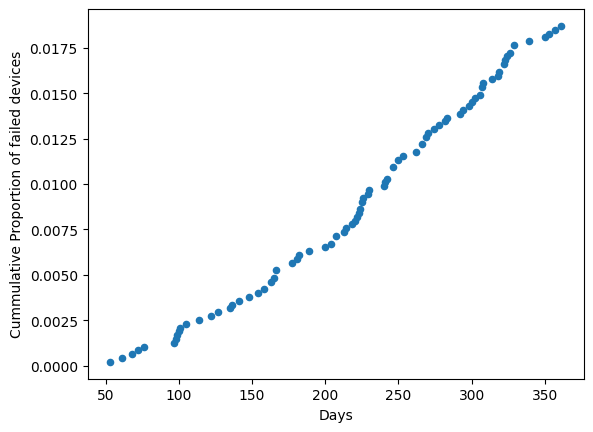

In [15]:
fail_df_new_train = fail_df_new.loc[:365].copy()
fail_df_new_test = fail_df_new.loc[365:].copy()
fail_df_new_train.plot.scatter(x="Days", y="Cummulative Proportion of failed devices")

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier


X_train = fail_df_new_train[["Days"]]
X_test = fail_df_new_test[["Days"]]
y_train = fail_df_new_train["Cummulative Proportion of failed devices"]
X_train2 = fail_df_new[["Days"]]
y_train2 = fail_df_new["Cummulative Proportion of failed devices"]
knn = KNeighborsClassifier(n_neighbors=5)

model = LinearRegression(fit_intercept=False)
model.fit(X=X_train, y=y_train)
model.predict(X=X_test)
#knn.fit(X_train, y=y_train)

exp_model = np.polyfit(X_train2["Days"],np.log(y_train2),1)
print(exp_model)
exp_y = np.exp(0.005933184 * fail_df_new["Days"]) * np.exp(-6.3955484378)

[ 5.93318396e-03 -6.39554844e+00]


(0.0, 0.05)

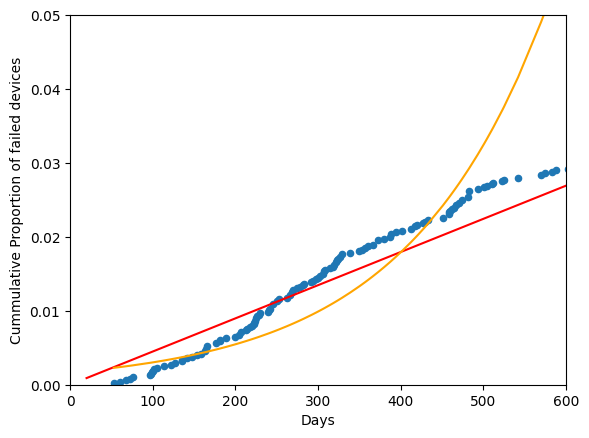

In [17]:
import numpy as np

X_new = pd.DataFrame()
# create a sequence of 200 evenly spaced numbers from 10 to 41
X_new["Days"] = np.linspace(20, 600, num=200)

# create a Series out of the predicted values
# (trailing underscore indicates fitted values)
y_new_ = pd.Series(
    model.predict(X_new), # y values in Series.plot.line()
    index=X_new["Days"]    # x values in Series.plot.line()
)

# plot the data, then the model
fail_df_new.plot.scatter(x="Days", y="Cummulative Proportion of failed devices")
y_new_.plot.line(color='red')
plt.plot(fail_df_new["Days"], exp_y, color='orange', )
plt.xlim(0,600)
plt.ylim(0,0.05)

In [18]:
model.coef_ * 100


array([0.00448814])

In [19]:
model.intercept_

0.0

Linear regression function based on Lab data:  Y= 0.0000448814x

In [20]:
field_data['Data Source'].value_counts()
field_data_failed = field_data[field_data["Censoring Indicator"] == 'Failed']
field_data["Data Source"].value_counts()

Field    369
Name: Data Source, dtype: int64

In [21]:
total_field_appliance=field_data.Count.sum()
total_field_app_failure = field_data_failed.Count.sum()
total_field_app_failure

113

In [22]:
field_table = [["Not Failed", total_field_appliance-total_field_app_failure],["Failed", total_field_app_failure]]
field_df = pd.DataFrame(field_table, columns=["Failed or Not", "Count"])
field_df

,Failed or Not,Count
0,Not Failed,4615
1,Failed,113


In [23]:
field_df_cp = field_df.copy()
field_df_cp.Count = (field_df_cp["Count"]/field_df_cp["Count"].sum())
field_df_cp
fig2 = px.bar(field_df_cp, x=field_df_cp["Failed or Not"], y="Count", width=800, height=400,
    labels=dict(x="Appliance Status", color="Place"),
    )
fig2.update_layout(
    title="Appliance Status from Field Data",
    xaxis_title="Appliance Status",
    yaxis_title="Unit Count %",
    font=dict(
        size=18
    )
)
fig2.show()

In [24]:
#take the failed rows and divide their count by the days it took for a failure.
array2 = field_data_failed['Count']/(field_data_failed['Days']/365)
field_data_failed['Failures Per Year'] = array2
field_data_failed['Wear FPY'] =   field_data_failed[field_data_failed["Failure Mode"]=="Wear"]["Failures Per Year"]
field_data_failed['Cracked FPY'] = field_data_failed[field_data_failed["Failure Mode"]=="Cracked"]['Failures Per Year'] 
field_data_failed = field_data_failed.fillna(0)
field_data_failed.tail()

C:\Users\bradl\AppData\Local\Temp\ipykernel_1424\2009494677.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bradl\AppData\Local\Temp\ipykernel_1424\2009494677.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bradl\AppData\Local\Temp\ipykernel_1424\2009494677.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,Data Source,Censoring Indicator,Count,Days,Failure Mode,Failures Per Year,Wear FPY,Cracked FPY
263,Field,Failed,1,165,Cracked,2.212121,0.000000,2.212121
267,Field,Failed,1,100,Cracked,3.650000,0.000000,3.650000
282,Field,Failed,1,76,Cracked,4.802632,0.000000,4.802632
300,Field,Failed,1,166,Wear,2.198795,2.198795,0.000000
301,Field,Failed,1,148,Wear,2.466216,2.466216,0.000000


In [25]:
#Sum up two failure per year types
field_fpy = pd.pivot_table(data = field_data_failed, values=['Wear FPY', 'Cracked FPY'], index='Failure Mode', aggfunc=np.sum)
field_fpy

,Cracked FPY,Wear FPY
Failure Mode,,
Cracked,32.720052,0.000000
Wear,0.000000,151.992008


The above shows the different types of failures and the expected number of appliances that break due to the failure types.  Below we will create a scatter plot for the field data, then impose the linear regression formula found in the lab data onto the field data scatterplot.

In [26]:

field_data_failed["Days"].value_counts()
#create scatter plot with days on x axis and number of failures on y axis, may need to combine repeated days because
#first create a new dataframe with just the days, count, and failures per year
fail_df_new2 = field_data_failed[["Days","Count", "Failures Per Year"]].copy()
fail_df_new2

,Days,Count,Failures Per Year
0,181,1,2.016575
6,278,1,1.312950
9,493,1,0.740365
10,223,1,1.636771
12,269,1,1.356877
...,...,...,...
263,165,1,2.212121
267,100,1,3.650000
282,76,1,4.802632
300,166,1,2.198795


In [27]:
fail_df_new2 = fail_df_new2.groupby(fail_df_new2.Days).sum()
fail_df_new2.index.values

fail_df_new2["Total Fails so far"] = fail_df_new2["Count"].cumsum(axis=0)
fail_df_new2

,Count,Failures Per Year,Total Fails so far
Days,,,
53,1,6.886792,1
61,1,5.983607,2
68,1,5.367647,3
72,1,5.069444,4
76,1,4.802632,5
...,...,...,...
570,2,1.280702,109
575,1,0.634783,110
583,1,0.626072,111


In [28]:
#add new column for percentages
fail_df_new2["Cummulative Proportion of failed devices"] = fail_df_new2["Total Fails so far"]/(test["Count"].sum())
fail_df_new2["Days"] = fail_df_new2.index
fail_df_new2

,Count,Failures Per Year,Total Fails so far,Cummulative Proportion of failed devices,Days
Days,,,,,
53,1,6.886792,1,0.000210,53
61,1,5.983607,2,0.000420,61
68,1,5.367647,3,0.000631,68
72,1,5.069444,4,0.000841,72
76,1,4.802632,5,0.001051,76
...,...,...,...,...,...
570,2,1.280702,109,0.022909,570
575,1,0.634783,110,0.023119,575
583,1,0.626072,111,0.023329,583


<AxesSubplot: xlabel='Days', ylabel='Cummulative Proportion of failed devices'>

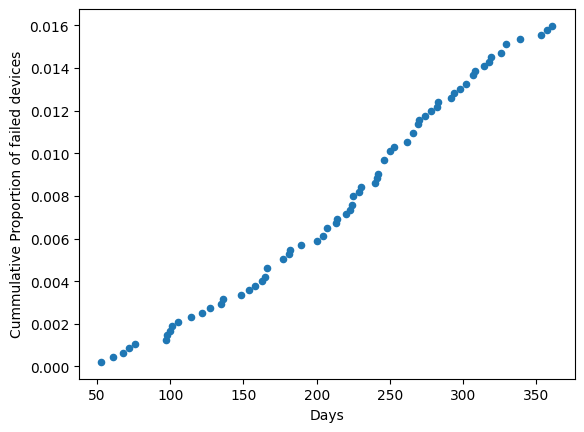

In [29]:
fail_df_new2_train = fail_df_new2.loc[:365].copy()
fail_df_new2_test = fail_df_new2.loc[365:].copy()
fail_df_new2_train.plot.scatter(x="Days", y="Cummulative Proportion of failed devices")

(0.0, 0.03)

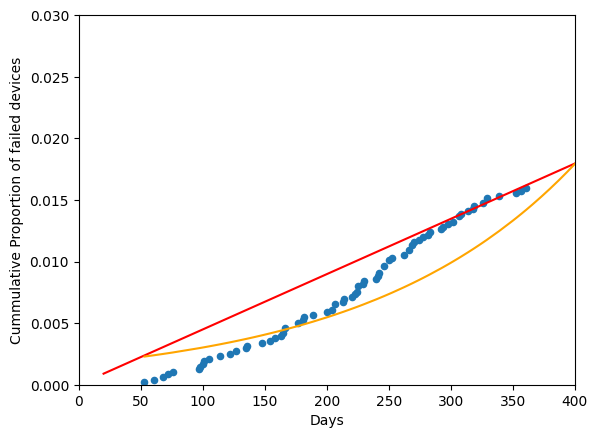

In [30]:
X_new2 = pd.DataFrame()
# create a sequence of 200 evenly spaced numbers from 10 to 41
X_new2["Days"] = np.linspace(20, 400, num=200)

# create a Series out of the predicted values
# (trailing underscore indicates fitted values)
y_new2_ = pd.Series(
    model.predict(X_new2), # y values in Series.plot.line()
    index=X_new["Days"]    # x values in Series.plot.line()
)

# plot the data, then the model
fail_df_new2_train.plot.scatter(x="Days", y="Cummulative Proportion of failed devices")
y_new_.plot.line(color='red')
plt.plot(fail_df_new["Days"], exp_y, color='orange', )
plt.xlim(0,400)
plt.ylim(0,0.03)

In [31]:
#Y= 0.0000448814x  ==> equation for linear line
fail_df_new2["Linear Lab Difference"] = (0.0000448814 * fail_df_new2["Days"]) - fail_df_new2["Cummulative Proportion of failed devices"]
fail_df_new2

,Count,Failures Per Year,Total Fails so far,Cummulative Proportion of failed devices,Days,Linear Lab Difference
Days,,,,,,
53,1,6.886792,1,0.000210,53,0.002169
61,1,5.983607,2,0.000420,61,0.002317
68,1,5.367647,3,0.000631,68,0.002421
72,1,5.069444,4,0.000841,72,0.002391
76,1,4.802632,5,0.001051,76,0.002360
...,...,...,...,...,...,...
570,2,1.280702,109,0.022909,570,0.002674
575,1,0.634783,110,0.023119,575,0.002688
583,1,0.626072,111,0.023329,583,0.002837


In [32]:
fail_df_new2["Linear Lab Difference"].mean()
fail_df_new2["Percent Linear Lab Difference"] = abs(fail_df_new2["Linear Lab Difference"]/ fail_df_new2["Cummulative Proportion of failed devices"] * 100)
fail_df_new2["Percent Linear Lab Difference"].median()

9.748075243877555

In [33]:
fail_df_new2["Exp Lab Difference"] = (np.exp(0.005933184 * fail_df_new2["Days"]) * np.exp(-6.3955484378))-fail_df_new2["Cummulative Proportion of failed devices"]
fail_df_new2["Percent Exp Lab Difference"] = abs(fail_df_new2["Exp Lab Difference"]/ fail_df_new2["Cummulative Proportion of failed devices"] * 100)
fail_df_new2

,Count,Failures Per Year,Total Fails so far,Cummulative Proportion of failed devices,Days,Linear Lab Difference,Percent Linear Lab Difference,Exp Lab Difference,Percent Exp Lab Difference
Days,,,,,,,,,
53,1,6.886792,1,0.000210,53,0.002169,1031.792216,0.002076,987.528741
61,1,5.983607,2,0.000420,61,0.002317,551.314389,0.001976,470.196753
68,1,5.367647,3,0.000631,68,0.002421,384.036923,0.001868,296.251322
72,1,5.069444,4,0.000841,72,0.002391,284.382262,0.001718,204.325948
76,1,4.802632,5,0.001051,76,0.002360,224.589466,0.001569,149.307858
...,...,...,...,...,...,...,...,...,...
570,2,1.280702,109,0.022909,570,0.002674,11.670688,0.026204,114.384565
575,1,0.634783,110,0.023119,575,0.002688,11.626162,0.027473,118.832123
583,1,0.626072,111,0.023329,583,0.002837,12.159589,0.029722,127.402258


In [34]:
import plotly.express as px
from plotly.subplots import make_subplots
fig3 = px.area(fail_df_new2, x="Days", y="Linear Lab Difference", title="Difference between Lab Linear Regression and Field datapoints")
fig4 = px.area(fail_df_new2, x="Days", y="Exp Lab Difference", title="Difference between Lab Exponential Regression and Field datapoints")
fig3.update_xaxes(range=[53, 400])
fig3.update_yaxes(range=[-.004, .005])
fig4.update_xaxes(range=[53, 400])
fig4.update_yaxes(range=[-.004, .005])
fig3.show()
fig4.show()

At 400 days, both models are around equal to each other in determiniing how many units will fail.  However, as the days go into the 600s the exponential regression equation gathered from the lab study data becomes a lot less reliable versus the linear regression equation.

In [35]:
fig4.update_xaxes(range=[400, 640])
fig4.update_yaxes(range=[-.004, .06])
fig3.update_yaxes(range=[-.004, .06])
fig3.update_xaxes(range=[400, 640])
fig3.show()
fig4.show()


The exponential regression is overestimating the number of failures that will occure within the time frame between day 400 and day 640, unlike the linear regression equation which is only slightly overestimating the number of device failures.  Early in the appliance lifespan, utilizing the exponential regression analysis of lab data can lead to an accurate representation of the amount of failures that will happen in the field, unlike the linear regression equation which drastically over estimates the field failures.


In [36]:
exp_dif_mean = fail_df_new2["Percent Exp Lab Difference"].mean()
exp_dif_median = fail_df_new2["Percent Exp Lab Difference"].median()
print(exp_dif_mean)
print(exp_dif_median)
lin_dif_mean = fail_df_new2["Percent Linear Lab Difference"].mean()
lin_dif_median = fail_df_new2["Percent Linear Lab Difference"].median()
print(lin_dif_mean)
print(lin_dif_median)

52.52940925604289
24.42705992622902
55.424259011177504
9.748075243877555


In the end, we have found that both types of models come extremely close to the real proportions in our early days of test data.  However, as the time progresses, the exponential model becomes quite innacurate at predicting the correct failure proportion compared to the linear regression model.  The data above shows that both models have a mean difference of 50% compared to the actual failure proportion, but since we are talking about tiny proportions of total failures(<3%), an increase of 1% total failures due to using the lab model could be attributed to the margin of error, so we believe the tests are accurate enough.

Grab Backblaze data and compare it to manufacturer wear statements


In [37]:
bblaze_data_1 = pd.read_csv("2 Field Failure-Time Data/Backblaze1Q2016.csv")
bblaze_data_1_failed = bblaze_data_1[bblaze_data_1["Censored"] != True]
bblaze_data_1

,Serial Number,Model,Start Date,End Date,Hours Lower,Hours Upper,Failed,Censored,Drive Model Name
0,13H2B97AS,35,10/15/2013,3/31/2016,1349,18433,0,True,TOSHIBA DT01ACA300
1,13H3012AS,35,10/15/2013,9/8/2014,1256,9122,0,True,TOSHIBA DT01ACA300
2,13H32WEAS,35,4/26/2013,3/31/2016,8,25684,0,True,TOSHIBA DT01ACA300
3,13H6A0DGS,35,4/20/2013,9/2/2014,13,12006,0,True,TOSHIBA DT01ACA300
4,13H6A21GS,35,5/22/2013,3/31/2016,14,25050,0,True,TOSHIBA DT01ACA300
...,...,...,...,...,...,...,...,...,...
75291,Z4D1X9LF,32,8/4/2015,3/31/2016,10,5770,0,True,ST6000DX000
75292,Z4D1XXJX,32,6/27/2015,3/31/2016,3,6675,0,True,ST6000DX000
75293,Z4D1XY09,32,6/2/2015,3/31/2016,7,7280,0,True,ST6000DX000
75294,Z4D29XNF,32,8/22/2015,3/31/2016,8,5336,0,True,ST6000DX000


In [38]:
bblaze_data_1_failed

,Serial Number,Model,Start Date,End Date,Hours Lower,Hours Upper,Failed,Censored,Drive Model Name
57,2EG33YWJ,5,2/5/2015,3/17/2015,9,968,1,False,HGST HUH728080ALE600
70,2EG3P7PP,5,2/5/2015,11/20/2015,9,6920,1,False,HGST HUH728080ALE600
140,45C8K0QIFMYB,36,5/21/2015,6/14/2015,58,634,1,False,TOSHIBA MD04ABA400V
144,45C9K0XLFMYB,36,5/21/2015,8/5/2015,127,1951,1,False,TOSHIBA MD04ABA400V
163,45CHK11QFMYB,36,5/21/2015,7/12/2015,128,1376,1,False,TOSHIBA MD04ABA400V
...,...,...,...,...,...,...,...,...,...
75151,Z4D0C8EM,32,4/3/2015,8/25/2015,72,3535,1,False,ST6000DX000
75211,Z4D0DBP9,32,4/10/2015,9/8/2015,29,3653,1,False,ST6000DX000
75225,Z4D0DGBW,32,4/10/2015,4/13/2015,30,102,1,False,ST6000DX000
75230,Z4D0DKTA,32,4/16/2015,6/21/2015,53,1636,1,False,ST6000DX000


In [39]:
bblaze_data_1_failed["Hours Lower"].value_counts()

10       62
9        60
12       57
13       52
8        49
         ..
17817     1
21174     1
14099     1
4319      1
27        1
Name: Hours Lower, Length: 1635, dtype: int64

Would like to add manufacturer column to the above data frame, need to add column and column value based on drive model name, ie toshiba model name = Toshiba manufacturer.

In [40]:
bblaze14 = pd.read_csv("2 Field Failure-Time Data/BackblazeDrive14.csv")
bblaze14

,Hours,Censoring Indicator,Truncation Hours,Truncation Indicator
0,15211,Failed,9369,Left
1,10110,Right,9541,Left
2,21692,Failed,9314,Left
3,21749,Right,9647,Left
4,11550,Right,9,Left
...,...,...,...,...
4699,4873,Right,10,Left
4700,8447,Right,13,Left
4701,11230,Right,9,Left
4702,10634,Right,11,Left


In [41]:
bblaze14["Censoring Indicator"].value_counts()

Right     2997
Failed    1707
Name: Censoring Indicator, dtype: int64

In [42]:
bblaze14_failed = bblaze14[bblaze14["Censoring Indicator"] == 'Failed']
bblaze14_not_failed = bblaze14[bblaze14["Censoring Indicator"] != 'Failed']

bblaze14_table = [["Not Failed", bblaze14_not_failed.shape[0]],["Failed", bblaze14_failed.shape[0]]]
bblaze14_table_2 = pd.DataFrame(bblaze14_table, columns=["Failed or Not", "Count"])

bblaze14_table_2.Count = (bblaze14_table_2["Count"]/bblaze14_table_2["Count"].sum())

In [43]:
bblaze14_failed

,Hours,Censoring Indicator,Truncation Hours,Truncation Indicator
0,15211,Failed,9369,Left
2,21692,Failed,9314,Left
7,21977,Failed,9524,Left
12,17850,Failed,8853,Left
13,15416,Failed,9525,Left
...,...,...,...,...
4670,17264,Failed,3853,Left
4671,19278,Failed,3707,Left
4673,15589,Failed,3850,Left
4692,19555,Failed,1442,Left


In [44]:
bblaze_figure = px.bar(bblaze14_table_2, x=bblaze14_table_2["Failed or Not"], y="Count", width=800, height=400,
    labels=dict(x="Failure Rate", color="Place"),
    )
bblaze_figure.update_layout(
    title="BBlaze Drive 14",
    xaxis_title="Failure Rate",
    yaxis_title="Count %",
    font=dict(
        size=18
    )
)
bblaze_figure.show()

<AxesSubplot: xlabel='Truncation Hours', ylabel='Hours'>

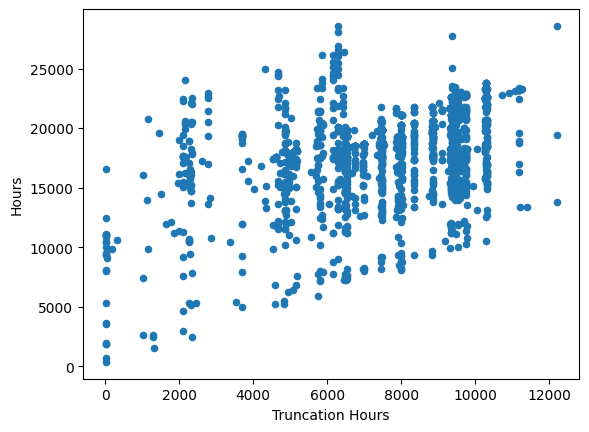

In [45]:
bblaze14_train = bblaze14_failed.copy()
bblaze14_test = bblaze14_failed.copy()
bblaze14_train.plot.scatter(x="Truncation Hours", y="Hours")

In [46]:
bb14_X_train = bblaze14_train[["Truncation Hours"]]
bb_14_X_test = bblaze14_test[["Truncation Hours"]]
bb_14_y_train = bblaze14_train["Hours"]

knn = KNeighborsClassifier(n_neighbors=5)

model14 = LinearRegression(fit_intercept=False)
model14.fit(X=X_train, y=y_train)
model14.predict(X=X_test)

bb14_exp_model = np.polyfit(bb14_X_train["Truncation Hours"],np.log(bb_14_y_train),1)
print(exp_model)
bb14_exp_y = np.exp(5.69401330e-05 * bblaze14_train["Truncation Hours"]) * np.exp(9.31565897e+00)

[ 5.93318396e-03 -6.39554844e+00]


c:\Users\bradl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Truncation Hours
Feature names seen at fit time, yet now missing:
- Days




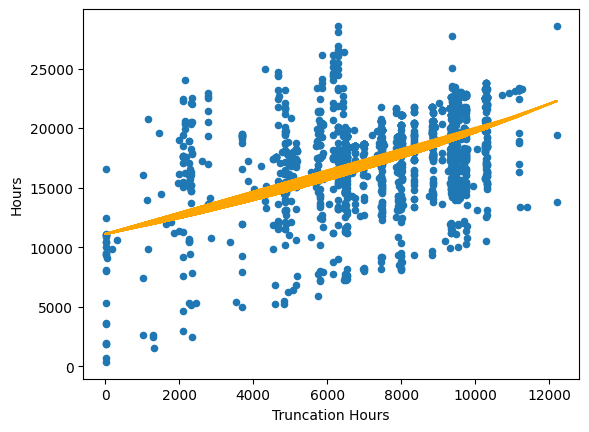

In [47]:
bb14_X_new = pd.DataFrame()

bb14_X_new["Truncation Hours"] = np.linspace(0, 13000, num=50)

bb14_y_new_ = pd.Series(model.predict(bb14_X_new),index=bb14_X_new["Truncation Hours"])

bblaze14_train.plot.scatter(x="Truncation Hours", y="Hours")
#bb14_y_new_.plot.line(color='red')
plt.plot(bblaze14_train["Truncation Hours"], bb14_exp_y, color='orange', )